In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score,balanced_accuracy_score

In [2]:
# ! pip install umap-learn

#### Display options

In [3]:
pd.set_option('display.max_row', 25)
pd.set_option('display.max_column', 25)

##### Load the embeddings representations for the ACCP (which is the training dataset) and the HCP dataset (which will be the input for the trained SVM classifier)

In [4]:
embeddings_ACCP= pd.read_csv("/neurospin/dico/adufournet/Runs/01_genetics_paracingular/Input/ACCpatterns_cingulate_full_embeddings.csv")#, index_col=0)
embeddings_ACCP.head()
embeddings_ACCP.shape

(341, 257)

In [5]:
labels_ACCP = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/subjects_labels.csv")
labels_ACCP = labels_ACCP[['long_name','Right_PCS']]

In [6]:
def encoder(df, col):
    code = {'present':1,
            'absent':0}
    df[col] = df[col].map(code)
    return df

encoder(labels_ACCP,'Right_PCS') 

,long_name,Right_PCS
0,nih_chp_04701_t1,0
1,nih_chp_01534_t1,1
2,nih_chp_04623_t1,1
3,nih_chp_01503_t1,0
4,nih_chp_00404_t1,1
...,...,...
376,a0005_t1_s03,1
377,a0006_t1_s03,0
378,a0001_t1_s03,1
379,a0016_t1_s03,1


In [7]:
embeddings_HCP = pd.read_csv("/neurospin/dico/adufournet/Runs/01_genetics_paracingular/Input/hcp_cingulate_full_embeddings.csv", index_col=0)
embeddings_HCP.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,...,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,,,,,
100206,-16.269560,-26.450573,6.987823,13.866329,-23.358473,11.751495,15.482762,-28.254500,2.468554,29.265993,5.080901,-7.247855,...,15.884296,-10.469205,0.255839,-26.942001,9.252998,9.163906,6.532629,10.676800,-14.139249,0.045611,-35.327550,-13.927697
100307,0.811358,-18.127650,-4.755681,22.113867,-5.715726,15.947124,9.402464,-19.022861,-13.003400,13.321704,-0.777160,-17.446222,...,14.628305,-5.092073,6.490175,-8.862627,13.441197,2.842024,6.585532,25.127434,-6.861317,15.825949,-23.992393,-9.157214
100408,20.104237,19.609802,-11.392226,-22.513320,1.335086,-0.447604,-11.521453,-30.562178,-12.678901,13.097897,-1.685708,-3.823623,...,22.036820,4.887552,28.514357,-9.187751,-13.514122,-2.253131,2.700759,7.052255,-21.251228,-8.701427,-5.803285,-24.713255
100610,2.555209,-15.088083,36.982754,-11.100479,-20.611986,-8.845087,-1.762242,-5.469845,-0.281939,12.722241,-0.980051,13.480085,...,-12.174725,-18.633965,-14.625642,-21.709137,7.999446,23.296196,2.751116,-6.180230,-41.432198,0.679659,-29.611362,-17.983616
101006,1.584482,-14.349580,0.897325,6.069071,-2.019094,34.008507,-11.613828,-19.883879,11.140767,4.942825,-8.645184,-3.193267,...,-15.340488,-10.146723,-17.744781,12.339481,5.968554,16.571490,7.573746,-6.312110,-21.530790,18.567806,-16.335620,3.381026


#### Scaler

In [8]:
ebdd_lbl_ACCP = embeddings_ACCP.set_index('ID').join(labels_ACCP.set_index('long_name'))
X = ebdd_lbl_ACCP.drop('Right_PCS', axis=1)
y = ebdd_lbl_ACCP['Right_PCS']

The scaler is fited on the ACCP database at first, it transforms it and then transforms the HCP dataset.
Is it better to fit one everything and transform everything at once ?

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
scl_bdd_hcp = scaler.transform(embeddings_HCP)
X.shape ,scl_bdd_hcp.shape

((341, 256), (1114, 256))

#### SVC model, training on the ACCP database

In [10]:
#from train_multiple_classifiers import train_classifiers,train_one_classifier
model = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

In [11]:
outputs = {}
val_pred = cross_val_predict(model, X, y, cv=5)
auc = roc_auc_score(y, val_pred)
outputs['labels_pred'] = val_pred
outputs['auc'] = auc
outputs['balanced_accuracy_score'] = balanced_accuracy_score(y, val_pred)

In [12]:
outputs['auc'], outputs['balanced_accuracy_score']

(0.7621263395375071, 0.7621263395375071)

La valeur d'auc ci dessous n'est pas fiable car on s'entraîne sur l'ensemble du modèle pour tester sur l'ensemble du modèle.

In [13]:
model.fit(X,y)
roc_auc_score(y,model.predict_proba(X)[:,1]), balanced_accuracy_score(y, model.predict(X))

(0.9055978567399887, 0.8257014946418499)

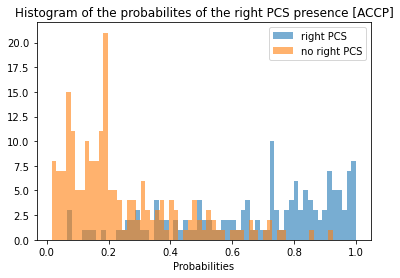

In [14]:
plt.hist(model.predict_proba(X)[y==1,1], bins=60, alpha=0.6, label='right PCS')
plt.hist(model.predict_proba(X)[y==0,1], bins=60, alpha=0.6, label='no right PCS')
plt.xlabel('Probabilities')
plt.title('Histogram of the probabilites of the right PCS presence [ACCP]')
plt.legend()
plt.show()

In [15]:
float((model.predict(X) == (model.predict_proba(X)>0.5)[:,1]).sum())/len(X)

0.9530791788856305

#### Classification of the HCP embeddings

In [16]:
val_pred = model.predict(X=scl_bdd_hcp)

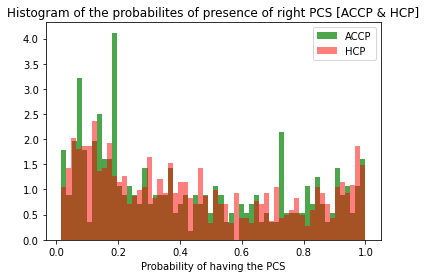

In [17]:
plt.hist(model.predict_proba(X)[:,1], bins=60, color='g', alpha=0.7, label='ACCP', density=True)
plt.hist(model.predict_proba(scl_bdd_hcp)[:,1], bins=60, color='red', alpha=0.5, label='HCP', density=True)
plt.xlabel('Probability of having the PCS')
plt.title('Histogram of the probabilites of presence of right PCS [ACCP & HCP]')
plt.legend()
plt.show()

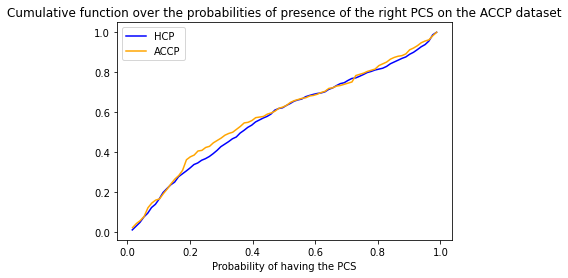

In [18]:
values_ACCP, base_ACCP = np.histogram(model.predict_proba(X)[:,1], bins=80)
cumulative_ACCP = np.cumsum(values_ACCP)
values_HCP, base_HCP = np.histogram(model.predict_proba(scl_bdd_hcp)[:,1], bins=80)
cumulative_HCP = np.cumsum(values_HCP)
# plot the cumulative function
plt.plot(base_HCP[:-1], cumulative_HCP/len(scl_bdd_hcp), c='blue', label='HCP')
#plot the survival function
#plt.plot(base_HCP[:-1], len(model.predict_proba(scl_bdd_hcp)[:,1])-cumulative_HCP, c='green', label = 'survival function')
plt.xlabel('Probability of having the PCS')
plt.legend()
plt.title('Cumulative function over the probabilities of presence of the right PCS on the HCP dataset')

# plot the cumulative function
plt.plot(base_ACCP[:-1], cumulative_ACCP/len(X), c='orange', label='ACCP')
#plot the survival function
#plt.plot(base_ACCP[:-1], len(model.predict_proba(X)[:,1])-cumulative_ACCP, c='red', label = 'survival function')
plt.xlabel('Probability of having the PCS')
plt.legend()
plt.title('Cumulative function over the probabilities of presence of the right PCS on the ACCP dataset')
plt.show()

#### SVM classification between ACCP and HCP datasets

In [19]:
scd_bdd_hcp = pd.DataFrame(scl_bdd_hcp, columns=embeddings_HCP.columns)
scd_bdd_hcp['Dataset'] = 0

scd_bdd_ACCP = pd.DataFrame(X,columns=embeddings_HCP.columns)
scd_bdd_ACCP['Dataset'] = 1

In [20]:
scd_bdd_HCP_ACCP = pd.concat([scd_bdd_hcp,scd_bdd_ACCP], axis=0)
scd_bdd_HCP_ACCP

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,...,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256,Dataset
0,-1.407952,-2.060278,0.442340,1.262746,-1.664490,0.516097,1.367951,-0.249094,0.241753,1.653005,1.007525,-0.968782,...,-0.263852,-0.387313,-1.644946,1.037354,0.579531,-0.036738,0.223121,-0.565826,-0.630988,-2.621130,-0.653645,0
1,-0.065470,-1.427728,-0.464610,1.817154,-0.473631,0.863874,0.935349,0.350664,-1.176966,0.252411,0.584909,-1.796190,...,0.302055,-0.008871,-0.024336,1.361399,0.078629,-0.031831,1.307759,-0.048032,0.645575,-1.590091,-0.305347,0
2,1.450863,1.440358,-0.977150,-1.182730,0.002289,-0.495093,-0.553350,-0.399019,-1.147211,0.232751,0.519364,-0.690969,...,1.352344,1.328060,-0.053479,-0.724158,-0.325076,-0.392211,-0.048931,-1.071814,-1.338587,0.064379,-1.441109,0
3,0.071589,-1.196718,2.758847,-0.415547,-1.479106,-1.191164,0.141000,1.231174,-0.010457,0.199753,0.570272,0.712907,...,-1.123138,-1.290661,-1.175879,0.940366,1.699275,-0.387540,-1.042137,-2.507606,-0.579697,-2.101189,-0.949772,0
4,-0.004706,-1.140591,-0.028028,0.738607,-0.224113,2.360991,-0.559922,0.294726,1.036961,-0.483615,0.017289,-0.639827,...,-0.229913,-1.480002,1.876193,0.783234,1.166456,0.059843,-1.052035,-1.091704,0.867379,-0.893636,0.610082,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,-1.095618,-0.814156,0.713558,-0.481586,0.533281,0.620425,-1.605755,-1.293654,-1.539376,1.498189,0.046666,-0.824644,...,1.284233,-3.313647,0.296082,-1.220952,-0.960692,-0.450504,-0.672430,-0.797303,1.161940,-2.163800,1.014625,1
337,0.545916,-0.885743,0.808064,0.668618,0.468354,-0.611600,-0.194598,-0.216098,2.809215,-0.057498,0.831695,-0.580761,...,1.000766,-0.104133,-0.854621,0.405617,1.877090,1.135257,-0.381970,-1.127111,0.693809,-0.772553,-0.804354,1
338,0.250884,0.009463,1.461193,-0.876846,1.156355,0.399715,-1.477657,-1.925259,0.380291,-0.683272,-0.133446,1.593317,...,0.257165,-0.852765,0.266556,0.977767,0.881106,-0.195119,-0.045615,-0.908843,1.961761,-0.892079,0.057918,1
339,-1.005971,0.764056,0.545726,1.609662,1.375298,-0.270035,1.134278,0.377388,0.898277,1.418802,0.962964,1.433022,...,0.255404,0.351116,-0.651109,0.285222,1.092017,-0.223076,0.927521,0.325137,-0.333908,0.052898,0.521657,1


In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(scd_bdd_HCP_ACCP.drop("Dataset", axis=1), scd_bdd_HCP_ACCP["Dataset"], test_size=0.01, random_state=40)

In [23]:
model2 = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

In [24]:
model2.fit(X_train,y_train)
val_predict = cross_val_predict(model2, X_train, y_train, cv=10)
auc = roc_auc_score(y_train, val_predict)
auc

0.7031511039490356

In [25]:
roc_auc_score(y_test, model2.predict_proba(X_test)[:,1])

0.9090909090909091

### Visualization (UMAP)

In [26]:
import umap

In [27]:
reducer = umap.UMAP()#random_state=5)
scd_bdd_ACCP['Right_PCS'] = y.values
scd_bdd_ACCP['Dataset'] = 'ACCP'
scd_bdd_ACCP['Prediction'] = model.predict(X)
scd_bdd_hcp['Right_PCS'] = -1
scd_bdd_hcp['Dataset'] = 'HCP'
scd_bdd_hcp['Prediction'] = model.predict(scl_bdd_hcp)

We fit the reducer only on the ACCP database, we concatenate then the two bases and we reduce the m together.

In [28]:
reducer.fit(scd_bdd_ACCP.drop(['Right_PCS','Dataset','Prediction'], axis=1))
HCP_and_ACCP = pd.concat([scd_bdd_hcp, scd_bdd_ACCP], axis=0)
embedding2D_HCP_and_ACCP = reducer.transform(HCP_and_ACCP.drop(['Right_PCS','Dataset','Prediction'], axis=1))

The first figure is made to observe the site effect between ACCP and HCP databases.

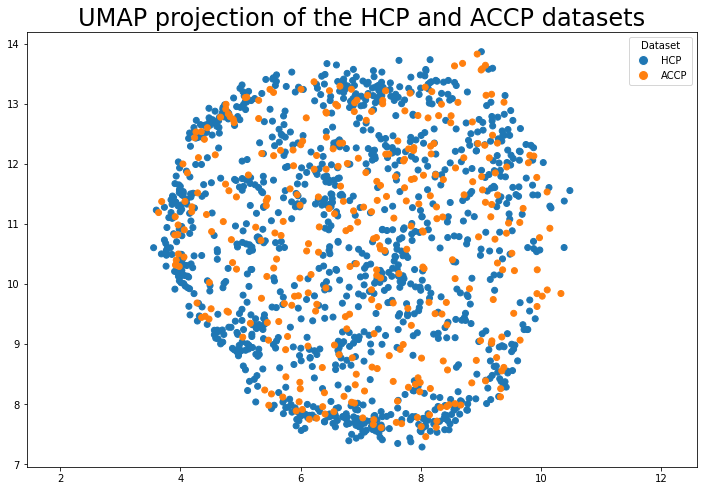

In [29]:
dataset_colors = [sns.color_palette()[0] if x == 'HCP' else sns.color_palette()[1] for x in HCP_and_ACCP['Dataset']]

plt.figure(figsize=(12, 8))
plt.scatter(
    embedding2D_HCP_and_ACCP[:, 0],
    embedding2D_HCP_and_ACCP[:, 1],
    c=dataset_colors)
plt.gca().set_aspect('equal', 'datalim')
unique_values = HCP_and_ACCP['Dataset'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=sns.color_palette()[i], markersize=10, 
                              label=f'{unique_values[i]}') 
                  for i in range(len(unique_values))]

plt.title('UMAP projection of the HCP and ACCP datasets', fontsize=24)
plt.legend(handles=legend_handles, title='Dataset', loc='best')
plt.show()

The second figure is made to point out the position of the people having the paracingular (1) (from the ACCP database), those who don't have it (0) (from the ACCP database), and those we don't know (-1) (from the HCP database).

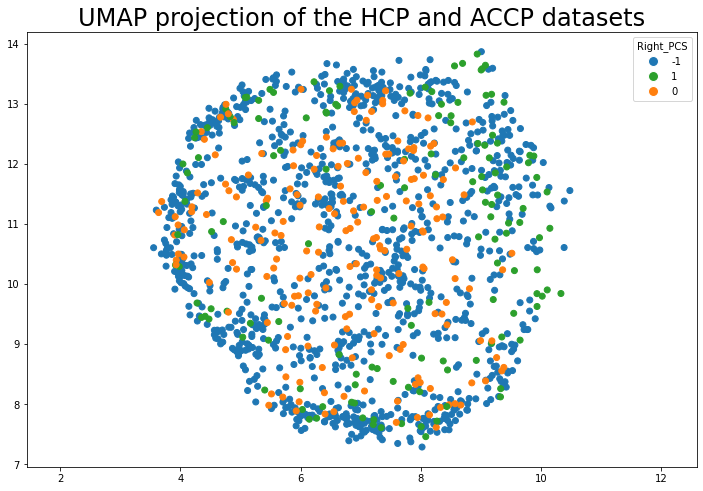

In [30]:
def plot_UMAP(ebb2D_dataset, initial_dataset, title, hue, coli=1):
    plt.figure(figsize=(12,8))
    plt.scatter(
        ebb2D_dataset[:, 0],
        ebb2D_dataset[:, 1],
        c=[sns.color_palette()[x+coli] for x in initial_dataset[hue]])
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontsize=24)
    unique_values = initial_dataset[hue].unique()
    colors = [sns.color_palette()[x+coli] for x in unique_values]
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=colors[i], markersize=10, 
                                label=f'{unique_values[i]}') 
                    for i in range(len(unique_values))]
    plt.legend(handles=legend_handles, title=hue, loc='best')
    plt.show()

plot_UMAP(embedding2D_HCP_and_ACCP, HCP_and_ACCP, 'UMAP projection of the HCP and ACCP datasets', 'Right_PCS')

Then, the following figure highlights the two classes in the ACCP database.

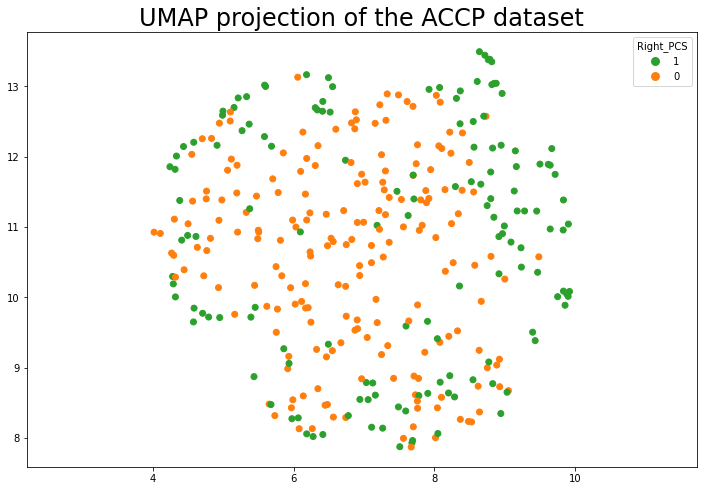

In [31]:
embedding2D_ACCP = reducer.transform(scd_bdd_ACCP.drop(['Right_PCS','Dataset','Prediction'], axis=1))

plot_UMAP(embedding2D_ACCP, scd_bdd_ACCP, 'UMAP projection of the ACCP dataset', 'Right_PCS')

We can do the same one by only keeping the 10 best ranked values given the SVM linear classification, on the ACCP database at first, and on the HCP then.

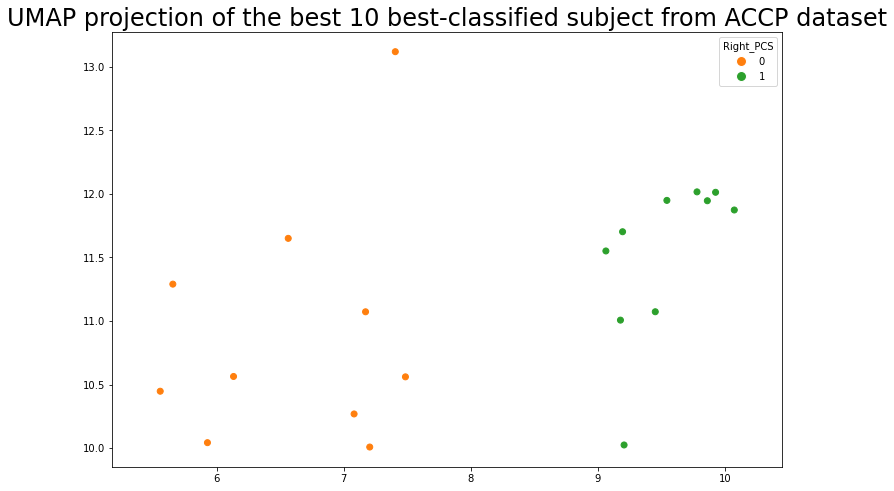

In [32]:
ACCP_proba_pred = model.predict_proba(X)
#ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[0:10]] # top 10 best ranked label 1
#ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[-10:]] # top 10 best ranked label 0
#scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[0:10]] # check if the prediction are also the ground truth (that's a yes)
#scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[-10:]] # check if the prediction are also the ground truth (that's a yes as well)
best_ACCP = pd.concat([scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[-10:]],scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[0:10]]], axis=0)
embedding2D_best_classified_ACCP = reducer.transform(best_ACCP.drop(['Right_PCS','Dataset','Prediction'], axis=1))
plot_UMAP(embedding2D_best_classified_ACCP, best_ACCP, 'UMAP projection of the best 10 best-classified subject from ACCP dataset', 'Right_PCS')


Let's see the SVC borders on the UMAP

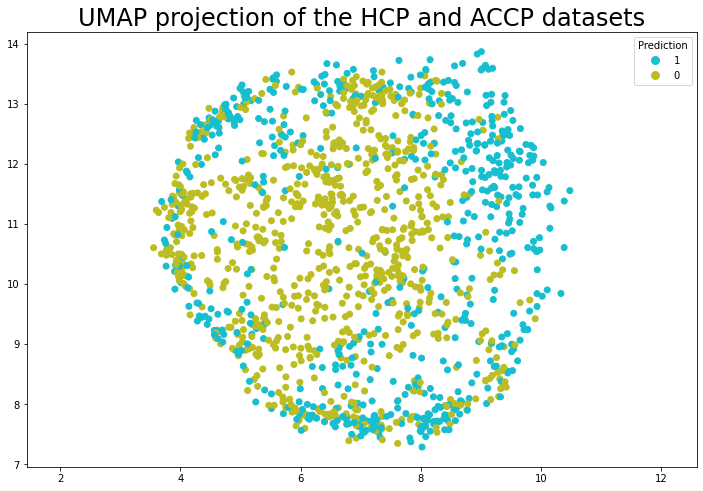

In [33]:
plot_UMAP(embedding2D_HCP_and_ACCP, HCP_and_ACCP, 'UMAP projection of the HCP and ACCP datasets', 'Prediction',-2)

We can get the ID of the best classified subject and see in the Anatomist if the paracingular is there or not.

In [34]:
ACCP_proba_pred = model.predict_proba(scd_bdd_hcp.drop(['Right_PCS', 'Dataset', 'Prediction'], axis=1))
ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[0:5]]

array([[1.38357115e-05, 9.99986164e-01],
       [1.56747994e-05, 9.99984325e-01],
       [3.14158038e-03, 9.96858420e-01],
       [4.31584939e-03, 9.95684151e-01],
       [4.38529041e-03, 9.95614710e-01]])

In [35]:
ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[-5:]]

array([[0.9785473 , 0.0214527 ],
       [0.97999898, 0.02000102],
       [0.98209278, 0.01790722],
       [0.9843246 , 0.0156754 ],
       [0.98435573, 0.01564427]])

First 5 people predicted without paracingulate sulcus.

In [36]:
embeddings_HCP.iloc[ACCP_proba_pred[:,0].argsort()[-5:]].index

Int64Index([732243, 725751, 171128, 131621, 138231], dtype='int64', name='ID')

First 5 people predicted with paracingulate sulcus.

In [37]:
embeddings_HCP.iloc[ACCP_proba_pred[:,0].argsort()[0:5]].index

Int64Index([693764, 959574, 219231, 151728, 101309], dtype='int64', name='ID')